In [ ]:
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


[INFO] Couldn't find torchinfo... installing it.


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
import torch
import torch.nn as nn
import functools
import torchvision.transforms as transforms
from torchinfo import summary

# Define the to_tensor function
def to_tensor(x, inverse=False):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    x = transform(x).unsqueeze(0).to(device)
    return x if not inverse else -x

# Define the UnetSkipConnectionBlock class with padding adjustments
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None, submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x).clamp(-1, 1)
        else:
            out = self.model(x)
            # Adjust the shape of x to match out
            if x.shape[2] != out.shape[2] or x.shape[3] != out.shape[3]:
                x = nn.functional.interpolate(x, size=(out.shape[2], out.shape[3]), mode='nearest')
            return torch.cat([x, out], 1)

# Define the UnetGenerator class
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        for _ in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)

    def forward(self, input):
        return self.model(input)

    def proceed(self, sketch):
        output = self(to_tensor(sketch))
        output = output[:, :3, :, :]  # Ensure only 3 channels are taken
        return output

In [ ]:
from torchinfo import summary

summary(model=UnetGenerator(input_nc=3, output_nc=3, num_downs=7),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
UnetGenerator (UnetGenerator)                                                                   [1, 3, 224, 224]     [1, 3, 128, 128]     --                   True
├─UnetSkipConnectionBlock (model)                                                               [1, 3, 224, 224]     [1, 3, 128, 128]     --                   True
│    └─Sequential (model)                                                                       [1, 3, 224, 224]     [1, 3, 128, 128]     --                   True
│    │    └─Conv2d (0)                                                                          [1, 3, 224, 224]     [1, 64, 112, 112]    3,072                True
│    │    └─UnetSkipConnectionBlock (1)                                                         [1, 64, 112, 112]    [1, 128, 64, 64]     41,819,776           True
│    │    └

In [ ]:
netG = UnetGenerator(input_nc=3, output_nc=3, num_downs=7)
netG.to(device)

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512,

In [ ]:
from PIL import Image
img = Image.open('/content/download.jpg')
sketch = netG.proceed(img)

In [ ]:
sketch.shape

torch.Size([1, 3, 128, 128])

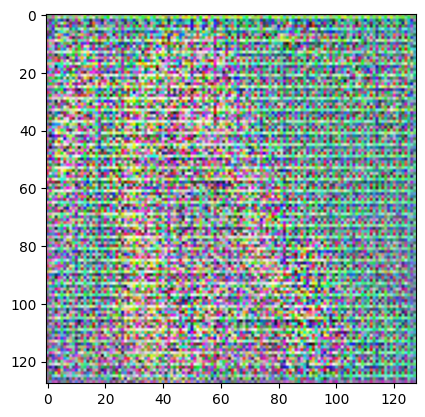

In [ ]:
import matplotlib.pyplot as plt
sketch_img = sketch.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
sketch_img.shape
sketch_img = (sketch_img - sketch_img.min()) / (sketch_img.max() - sketch_img.min())  # Normalize to [0, 1]

plt.imshow(sketch_img)
plt.show()

In [ ]:
model = UnetGenerator(input_nc=3, output_nc=3, num_downs=7).cuda()
model.load_state_dict(torch.load('/content/netG.pth'))
model.eval()

RuntimeError: Error(s) in loading state_dict for UnetGenerator:
	Missing key(s) in state_dict: "model.model.0.weight", "model.model.1.model.1.weight", "model.model.1.model.2.weight", "model.model.1.model.2.bias", "model.model.1.model.2.running_mean", "model.model.1.model.2.running_var", "model.model.1.model.3.model.1.weight", "model.model.1.model.3.model.2.weight", "model.model.1.model.3.model.2.bias", "model.model.1.model.3.model.2.running_mean", "model.model.1.model.3.model.2.running_var", "model.model.1.model.3.model.3.model.1.weight", "model.model.1.model.3.model.3.model.2.weight", "model.model.1.model.3.model.3.model.2.bias", "model.model.1.model.3.model.3.model.2.running_mean", "model.model.1.model.3.model.3.model.2.running_var", "model.model.1.model.3.model.3.model.3.model.1.weight", "model.model.1.model.3.model.3.model.3.model.2.weight", "model.model.1.model.3.model.3.model.3.model.2.bias", "model.model.1.model.3.model.3.model.3.model.2.running_mean", "model.model.1.model.3.model.3.model.3.model.2.running_var", "model.model.1.model.3.model.3.model.3.model.3.model.1.weight", "model.model.1.model.3.model.3.model.3.model.3.model.2.weight", "model.model.1.model.3.model.3.model.3.model.3.model.2.bias", "model.model.1.model.3.model.3.model.3.model.3.model.2.running_mean", "model.model.1.model.3.model.3.model.3.model.3.model.2.running_var", "model.model.1.model.3.model.3.model.3.model.3.model.3.model.1.weight", "model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.weight", "model.model.1.model.3.model.3.model.3.model.3.model.3.model.4.weight", "model.model.1.model.3.model.3.model.3.model.3.model.3.model.4.bias", "model.model.1.model.3.model.3.model.3.model.3.model.3.model.4.running_mean", "model.model.1.model.3.model.3.model.3.model.3.model.3.model.4.running_var", "model.model.1.model.3.model.3.model.3.model.3.model.5.weight", "model.model.1.model.3.model.3.model.3.model.3.model.6.weight", "model.model.1.model.3.model.3.model.3.model.3.model.6.bias", "model.model.1.model.3.model.3.model.3.model.3.model.6.running_mean", "model.model.1.model.3.model.3.model.3.model.3.model.6.running_var", "model.model.1.model.3.model.3.model.3.model.5.weight", "model.model.1.model.3.model.3.model.3.model.6.weight", "model.model.1.model.3.model.3.model.3.model.6.bias", "model.model.1.model.3.model.3.model.3.model.6.running_mean", "model.model.1.model.3.model.3.model.3.model.6.running_var", "model.model.1.model.3.model.3.model.5.weight", "model.model.1.model.3.model.3.model.6.weight", "model.model.1.model.3.model.3.model.6.bias", "model.model.1.model.3.model.3.model.6.running_mean", "model.model.1.model.3.model.3.model.6.running_var", "model.model.1.model.3.model.5.weight", "model.model.1.model.3.model.6.weight", "model.model.1.model.3.model.6.bias", "model.model.1.model.3.model.6.running_mean", "model.model.1.model.3.model.6.running_var", "model.model.1.model.5.weight", "model.model.1.model.6.weight", "model.model.1.model.6.bias", "model.model.1.model.6.running_mean", "model.model.1.model.6.running_var", "model.model.3.weight", "model.model.3.bias". 
	Unexpected key(s) in state_dict: "module.model.model.0.weight", "module.model.model.0.bias", "module.model.model.1.model.1.weight", "module.model.model.1.model.1.bias", "module.model.model.1.model.3.model.1.weight", "module.model.model.1.model.3.model.1.bias", "module.model.model.1.model.3.model.3.model.1.weight", "module.model.model.1.model.3.model.3.model.1.bias", "module.model.model.1.model.3.model.3.model.3.model.1.weight", "module.model.model.1.model.3.model.3.model.3.model.1.bias", "module.model.model.1.model.3.model.3.model.3.model.3.model.1.weight", "module.model.model.1.model.3.model.3.model.3.model.3.model.1.bias", "module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.1.weight", "module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.1.bias", "module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.1.weight", "module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.1.bias", "module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.3.weight", "module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.3.model.3.bias", "module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.5.weight", "module.model.model.1.model.3.model.3.model.3.model.3.model.3.model.5.bias", "module.model.model.1.model.3.model.3.model.3.model.3.model.5.weight", "module.model.model.1.model.3.model.3.model.3.model.3.model.5.bias", "module.model.model.1.model.3.model.3.model.3.model.5.weight", "module.model.model.1.model.3.model.3.model.3.model.5.bias", "module.model.model.1.model.3.model.3.model.5.weight", "module.model.model.1.model.3.model.3.model.5.bias", "module.model.model.1.model.3.model.5.weight", "module.model.model.1.model.3.model.5.bias", "module.model.model.1.model.5.weight", "module.model.model.1.model.5.bias", "module.model.model.3.weight", "module.model.model.3.bias". 

In [ ]:
torch.__version__

'2.3.0+cu121'

In [ ]:
!git clone https://github.com/Mukosame/Anime2Sketch.git

Cloning into 'Anime2Sketch'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 113 (delta 37), reused 36 (delta 23), pack-reused 45
Receiving objects: 100% (113/113), 17.25 MiB | 34.24 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [ ]:
pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
%cd Anime2Sketch

/content/Anime2Sketch


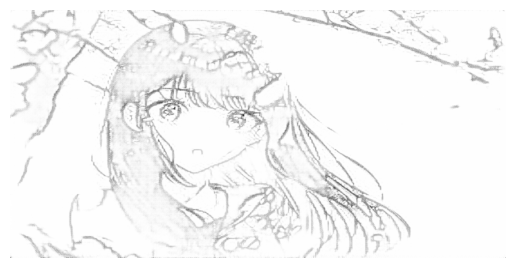

In [ ]:
import torch
from torchvision import transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from model import create_model

def preprocess_image(image_path, image_size=(512, 1024)):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0)
    return image

def postprocess_and_display(output_tensor):
    output_image = output_tensor.squeeze().detach().cpu()
    output_image = (output_image + 1) / 2  # Rescale to [0, 1]
    output_image = transforms.ToPILImage()(output_image)

    output_image = output_image.convert("L")

    plt.imshow(output_image, cmap='gray')
    plt.axis(False)
    plt.show()

    # output_image.save("/content/output_image.jpg")
    # output_image.show()

# Loading the model with pretrained weights when cd into Anime2sSketch
def load_pretrained_model():
    model = create_model('default')
    model.eval()
    return model

input_image_path = '/content/Anime2Sketch/test_samples/madoka.jpg'
output_image_path = '/content/Anime2Sketch/test_samples'

input_image = preprocess_image(input_image_path)

model = load_pretrained_model()

with torch.no_grad():
    output = model(input_image)

postprocess_and_display(output)